## Scripts to plot OOI DAS data. 

- Yiyu Ni (niyiyu@uw.edu)
- Feb 9th, 2022
- Dept. of Earth and Space Sciences
- University of Washington

In [20]:
# Uncomment the following two lines to install tqdm. This syntax will allow one to run sermeq.
# Only needs to be run once.

# import sys
# !{sys.executable} -m pip install tqdm scipy h5py matplotlib 

In [1]:
import h5py
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfilt, detrend, spectrogram
import glob

In [4]:
%%time
path = "/data/data2/south-data-ejm/hdd/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/"
filebase = 'South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_'
filelist = glob.glob(path + filebase + "2021-11-02T1701*")
filelist.sort()

data = np.array([])
timestamp = np.array([])

channel_to_plot = 20000

for i,file in enumerate(filelist):
    f = h5py.File(file, 'r')
    this_data = f['Acquisition']['Raw[0]']['RawData'][channel_to_plot, :].astype('int64')
    this_timestamp = f['Acquisition']['Raw[0]']['RawDataTime'][:] / 1000000
    data = np.append(data, this_data)
    timestamp = np.append(timestamp,this_timestamp)
    
    print("loaded file %d of %d"%(i,len(filelist)))
    
#     if i > 0:
#         break
    f.close()

with h5py.File(filebase + 'channel%d.h5'%channel_to_plot, 'w') as hf:
    hf.create_dataset('channel_%d'%channel_to_plot, data=data)
    hf.create_dataset('timestamp', data=timestamp)


loaded file 0 of 1
CPU times: user 6.1 s, sys: 9.07 s, total: 15.2 s
Wall time: 15.5 s


In [ ]:
t = np.linspace(0,60*len(filelist),data.shape[0])

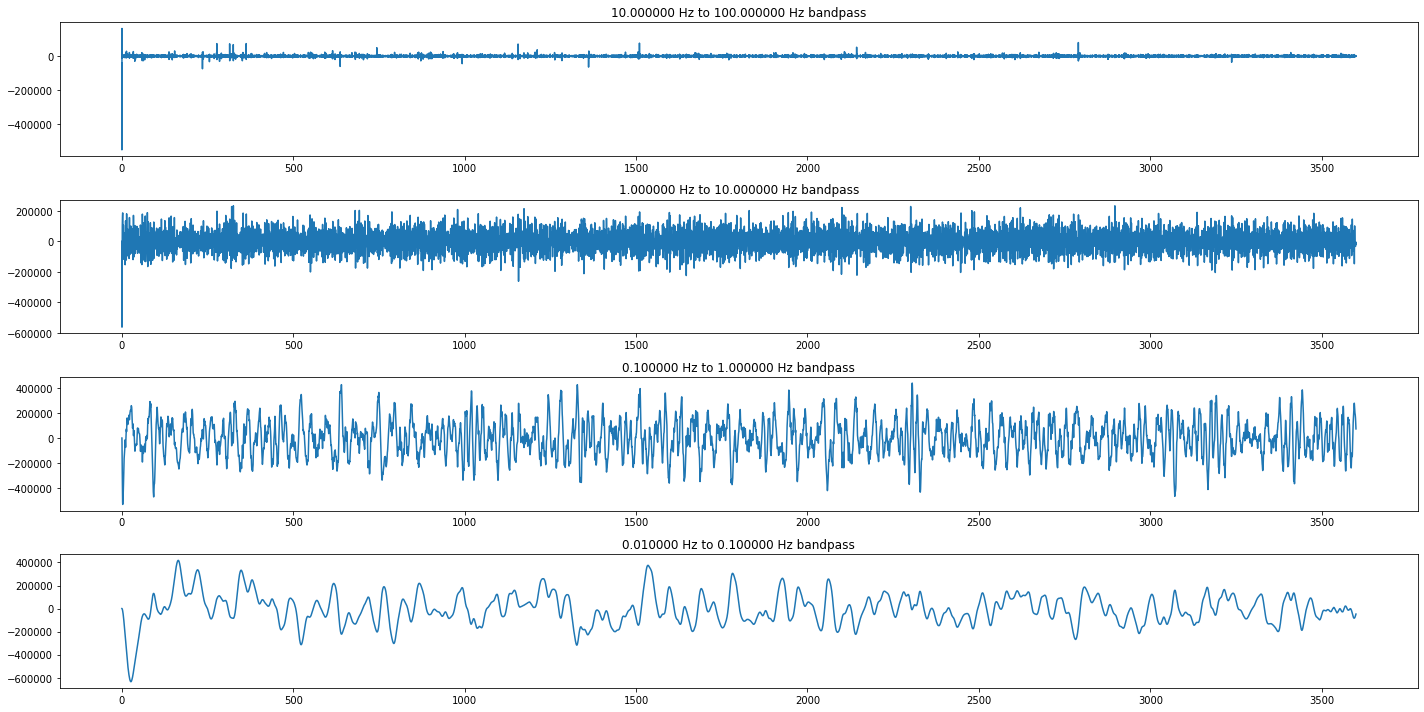

In [109]:
x_lims = list(map(datetime.utcfromtimestamp, [timestamp[0], timestamp[-1]]))
x_lims = mdates.date2num(x_lims)
y_lims = [0, 47500]

ranges = ((10,100),(1,10),(0.1,1),(0.01,0.1))
nsubplots = len(ranges)
fig, ax = plt.subplots(nsubplots,1,figsize = (20, 10))
fig.patch.set_facecolor('white') # Good for dark themed notebooks

for i in range(nsubplots):
    plt.subplot(nsubplots,1,i+1)
    
    sos = butter(2, ranges[i], 'bp', fs=1000, output='sos')
    filtered = sosfilt(sos, detrend(data) )

    plt.tight_layout()
    plt.plot(t,filtered)
    plt.title('%f Hz to %f Hz bandpass'%(ranges[i][0],ranges[i][1]))

<ipython-input-117-eca3d7a5570a>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c=plt.pcolormesh(t, f, np.log10(Sxx), shading='flat',vmin=4,vmax=14)


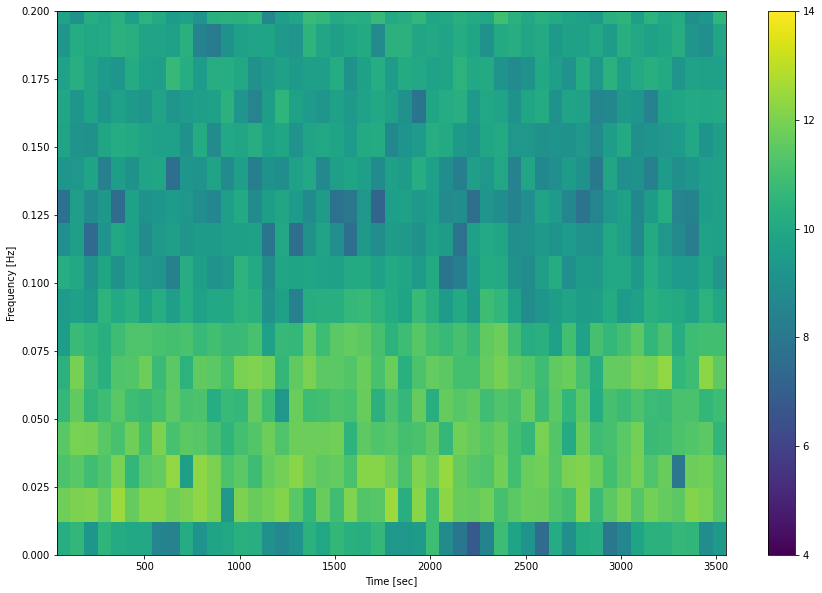

In [117]:

f, t, Sxx = spectrogram(data, 1/dt,nperseg=2**14)
fig, ax = plt.subplots(figsize = (15, 10))
fig.patch.set_facecolor('w')
c=plt.pcolormesh(t, f, np.log10(Sxx), shading='flat',vmin=4,vmax=14)
plt.colorbar(c)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
# plt.yscale('log')
plt.ylim(0,0.2)
plt.show()

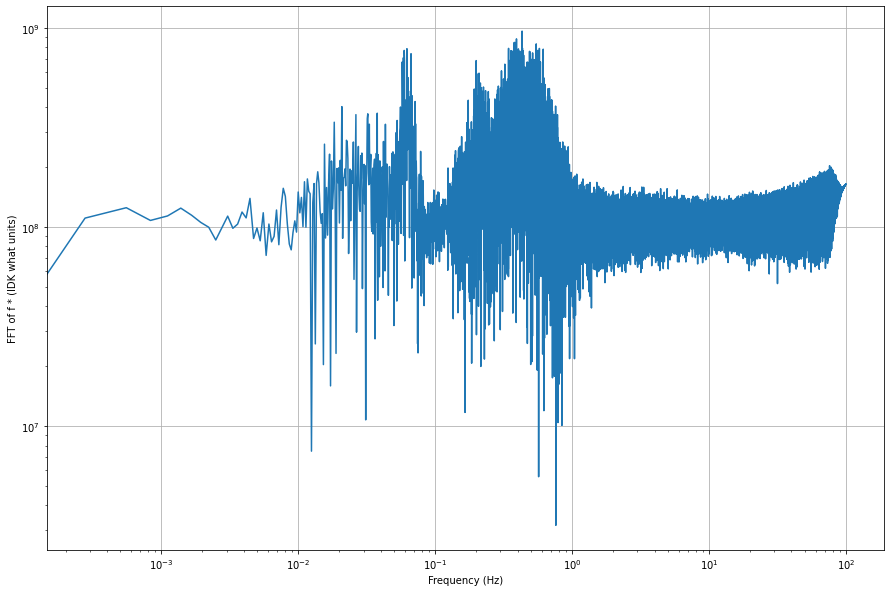

In [138]:
from scipy.fft import fft, fftfreq
N = len(data)
dataf = fft(data)
f = fftfreq(N, dt)[:N//2]
fig,ax=plt.subplots(figsize=(15,10))
fig.patch.set_facecolor('w')
plt.plot(f,f*np.abs(dataf[:N//2]))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('FFT of f * (IDK what units)')
plt.grid()

In [136]:
import sys
sys.getsizeof(data)/1e6

5.760096